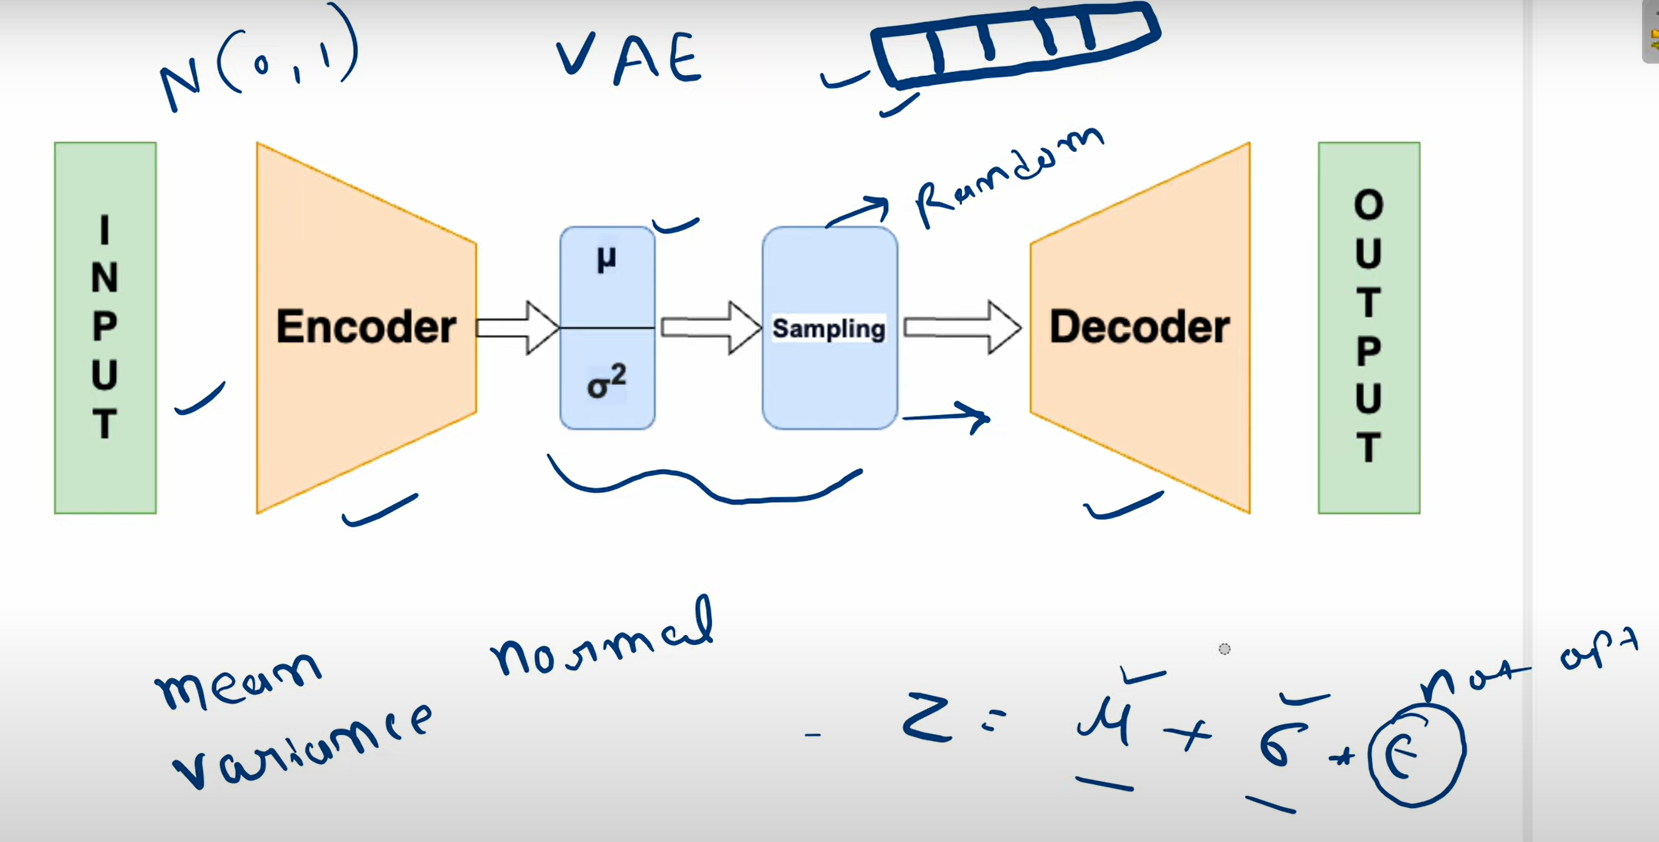

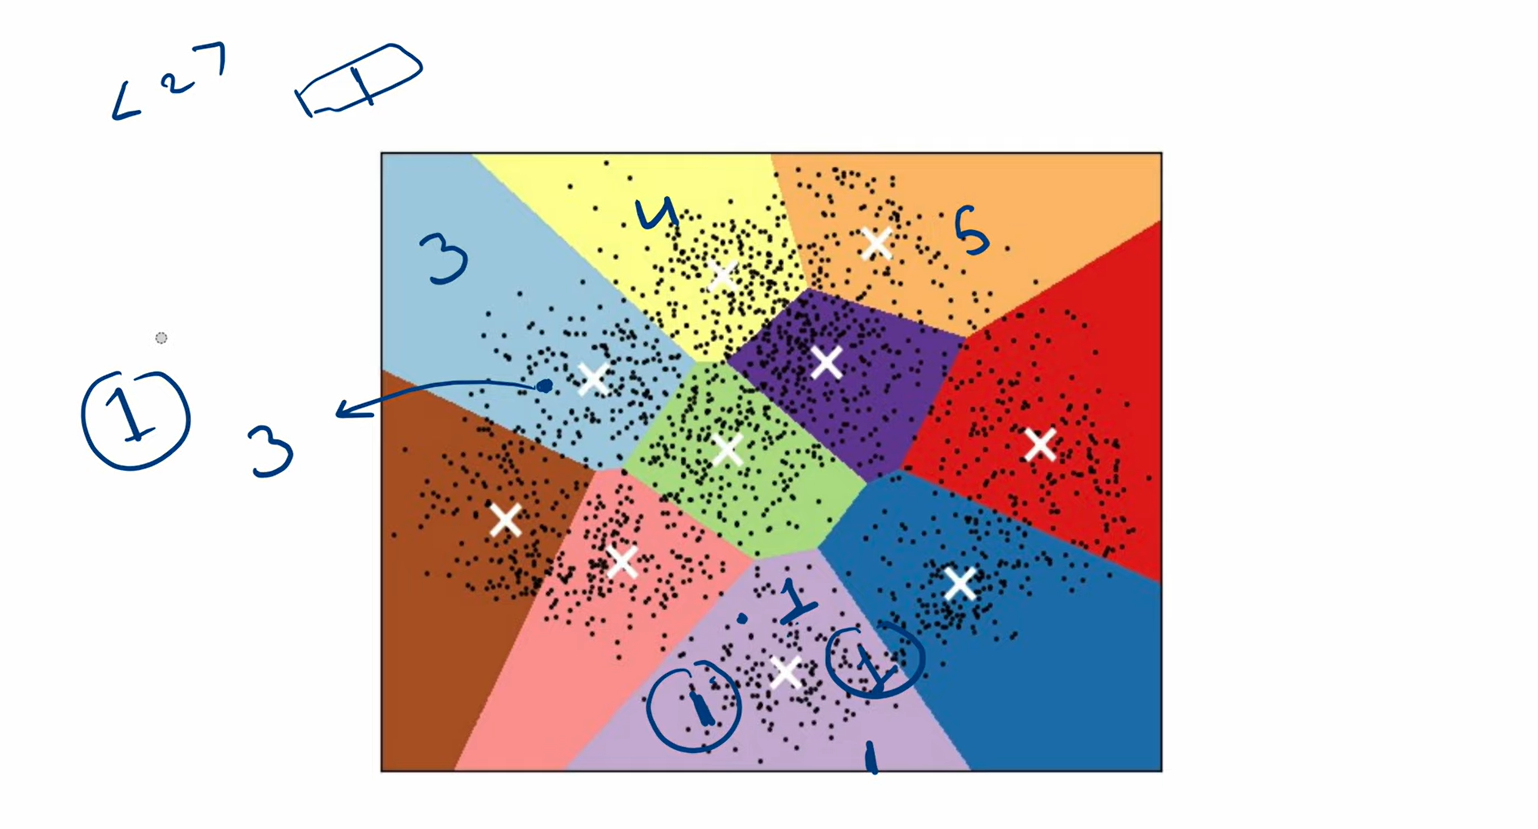

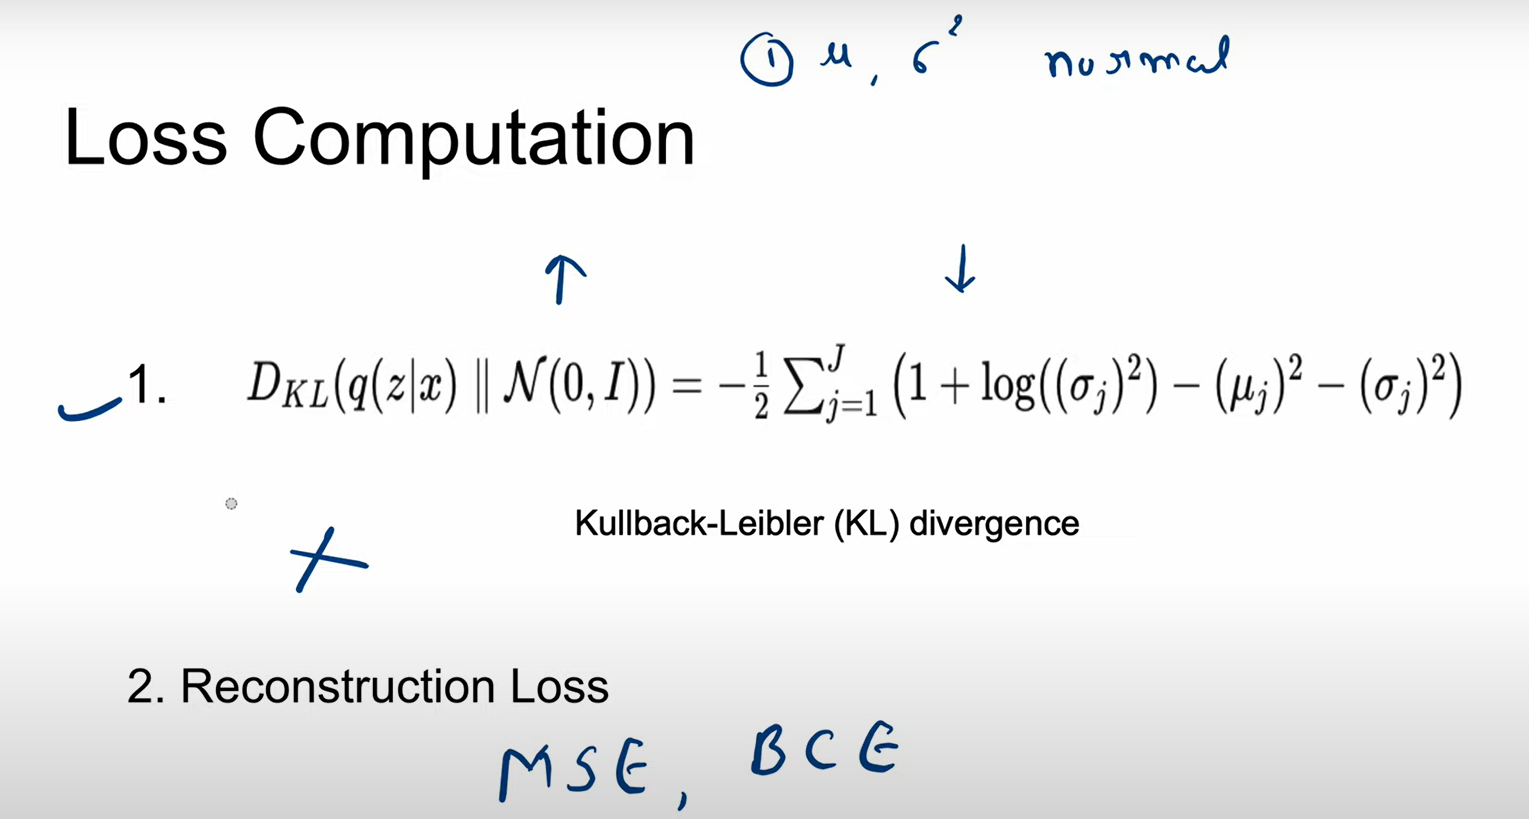

#Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt

#Preparing Data

In [2]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [3]:
batch_size = 32
num_epochs = 2

In [4]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.04MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.85MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

#Model Building

In [26]:
def sampling(z_mean, z_log_variance):
  batch_size, dim = z_mean.shape
  epsilon = torch.randn(batch_size, dim, device=z_mean.device)
  return z_mean + torch.exp(z_log_variance/2) * epsilon

In [27]:
batch_size = 128
num_epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.activation1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
    self.activation2 = nn.ReLU()
    self.fc = nn.Linear(32 * 7 * 7, 16)
    self.mean = nn.Linear(16, 2)
    self.log_variance = nn.Linear(16, 2)

  def forward(self, x):
    x = self.activation1(self.conv1(x)) #16x14x14
    x = self.activation2(self.conv2(x) ) #32x7x7
    x = x.view(x.shape[0], -1) #1568
    x = self.fc(x) #16
    z_mean = self.mean(x) #2
    z_log_variance = self.log_variance(x) #2

    return z_mean, z_log_variance

In [29]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(2, 32 * 7 * 7)
    self.convt1 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)
    self.activation1 = nn.ReLU()
    self.convt2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1)
    self.activation2 = nn.ReLU()
    self.convt3 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)
    self.activation3 = nn.Sigmoid()

  def forward(self, x):
    x = self.fc(x) #1568
    x = x.view(x.shape[0], 32, 7, 7) #32x7x7
    x = self.activation1(self.convt1(x)) #32x14x14
    x = self.activation2(self.convt2(x)) #16x28x28
    x = self.activation3(self.convt3(x)) #1x28x28

    return x

In [30]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, x):
    z_mean, z_log_variance = self.encoder(x)
    z = sampling(z_mean, z_log_variance)
    x = self.decoder(z)

    return z_mean, z_log_variance, x

In [44]:
def calculate_loss(output, image, z_mean, z_log_variance):
    reconstruction_loss = nn.functional.mse_loss(output, image, reduction='sum') / image.shape[0]

    kl_divergence = -0.5 * torch.sum(1 + z_log_variance - z_mean.pow(2) - torch.exp(z_log_variance)) / image.shape[0]

    loss = reconstruction_loss + kl_divergence
    return loss

In [45]:
model = VAE()
model.to(device)

VAE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation1): ReLU()
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (activation2): ReLU()
    (fc): Linear(in_features=1568, out_features=16, bias=True)
    (mean): Linear(in_features=16, out_features=2, bias=True)
    (log_variance): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=2, out_features=1568, bias=True)
    (convt1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation1): ReLU()
    (convt2): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (activation2): ReLU()
    (convt3): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (activation3): Sigmoid()
  )
)

In [46]:
optim = torch.optim.Adam(model.parameters())

In [47]:
for epoch in range(num_epochs):
  running_loss = 0.0
  for image, label in train_loader:
    image = image.to(device)

    z_mean, z_log_variance, output = model(image)

    loss = calculate_loss(output, image, z_mean, z_log_variance)

    optim.zero_grad()
    loss.backward()
    optim.step()

    running_loss += loss.item()

  print(f'Epoch: {epoch + 1}, Training Loss: {running_loss:.4f}')

Epoch: 1, Training Loss: 85107.8413
Epoch: 2, Training Loss: 77293.2212
Epoch: 3, Training Loss: 75851.8884
Epoch: 4, Training Loss: 75084.3492
Epoch: 5, Training Loss: 74441.4721
Epoch: 6, Training Loss: 74020.3716
Epoch: 7, Training Loss: 73672.1720
Epoch: 8, Training Loss: 73436.7760
Epoch: 9, Training Loss: 73209.2075
Epoch: 10, Training Loss: 73013.7353
Epoch: 11, Training Loss: 72843.4263
Epoch: 12, Training Loss: 72737.4358
Epoch: 13, Training Loss: 72572.5794
Epoch: 14, Training Loss: 72467.3880
Epoch: 15, Training Loss: 72327.2102
Epoch: 16, Training Loss: 72269.3566
Epoch: 17, Training Loss: 72124.4037
Epoch: 18, Training Loss: 72070.4058
Epoch: 19, Training Loss: 72056.5656
Epoch: 20, Training Loss: 71936.4045
Epoch: 21, Training Loss: 71882.4469
Epoch: 22, Training Loss: 71817.0064
Epoch: 23, Training Loss: 71762.1659
Epoch: 24, Training Loss: 71671.3762
Epoch: 25, Training Loss: 71651.2886
Epoch: 26, Training Loss: 71598.7020
Epoch: 27, Training Loss: 71521.4988
Epoch: 28,

In [49]:
with torch.no_grad():
  running_loss = 0.0
  for image, label in train_loader:
    image = image.to(device)

    z_mean, z_log_variance, output = model(image)

    loss = calculate_loss(output, image, z_mean, z_log_variance)

    running_loss += loss.item()

  print(f'Testing Loss: {running_loss:.4f}')

Testing Loss: 71127.1958


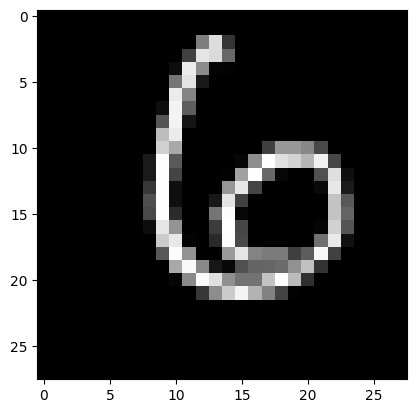

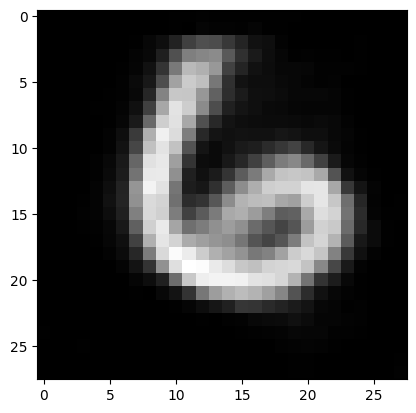

In [57]:
image, label = test_data[100]
image = image.numpy().squeeze()
plt.imshow(image, cmap='gray')
plt.show()

image, label = test_data[100]
image = image.to(device)
image = image.unsqueeze(0)

# Assuming the reconstructed image is the third element of the tuple
z_mean, z_log_variance, reconstructed_image = model(image)

reconstructed_image = reconstructed_image.cpu().detach().numpy().squeeze()
plt.imshow(reconstructed_image, cmap='gray')
plt.show()